In [2]:
from matplotlib.colors import ListedColormap
import re, seaborn as sns

In [3]:
import collections
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from collections import OrderedDict
import pandas as pd
from pymongo import MongoClient
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
import re
import emoji
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer
import datetime

# Collect data

In [4]:
host = "localhost"
port = "27017"
username = "accretioadmin"
password = "adminaccretio&2017"
authSource = "admin"

def _connect_mongo(db):
    if username and password:
        conn = MongoClient(host=host,
                            port=int(port),
                            username=username,
                            password=password,
                           authSource=authSource)
    else:
        conn = MongoClient(host, port)
        
    return conn[db]    


def read_mongo(db, collection, query={}):
    db = _connect_mongo(db=db)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))
    return df

In [ ]:
# col = df.columns
# df.to_csv("posts_advyteam.csv",index= False, header = col)

In [5]:
df = read_mongo("connectTimeline", "post")

df["post_id"] = df["_id"].astype(str)

df = df[["post_id","registrationNumber","body"]]

df["registrationNumber"] = df["registrationNumber"].astype(str)
df["body"].dropna()
print(df.shape)
df = df[500:]

(1775, 3)


In [6]:
df.head(1)

,post_id,registrationNumber,body
500,5c2ded63a4791700013bfeb1,00025,Souhaitons la bienvenue à ma voisine de bureau...


In [ ]:
# df = pd.read_csv("posts.csv")
# df = df[500:]

# Data preparation

In [7]:
days = ["terminer","dej","read","qu","bon","actually","itbu","amir","kods","dé","année","début","dweck","nan","monday","year","wednesday","bu","meta4","lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi","dimanche"]
verbs = ["dém","réponse","nshalah","voir","nom","nqué","perdre","chercher","partagerr","aller","decide",
"chose","passer","jour","monsieur","madame","qotd","sma","donne","semaine","journée",
"prendre","temps","réponse""best","ooredoo","amen","naimos","acretio","faire","pouvoir",
"savoir","lire","dire","souhaiter","ien","saa","venir","weekend","number","donner",
"parler","tenir","Connaitre"," Demander","sortir"]

In [8]:
@Language.factory('french_lemmatizer')
def create_lemmatizer(nlp, name):
    return LefffLemmatizer()   


In [9]:
def replace_word(text, findWord, replaceWord):
    return ' '.join(replaceWord if word == findWord else word for word in text.split(' '))

In [10]:
nlp = spacy.load('fr_core_news_md')
nlp.add_pipe('french_lemmatizer', name='lefff')  
def replace_lemma(text):  
    doc = nlp(text)
    for d in doc:
        if(d.pos_ != "PROPN" and d.pos_ != "NUM" and d.pos_ != "AUX" and d.pos_ !='DET' and d.pos_ !='PRON' and d.pos_ !='ADJ' and d.pos_ !='ADV'):
            text = replace_word(text, d.text, d.lemma_)
        else:
            text = replace_word(text, d.text, '')        
    return text 

In [11]:
def _remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

final_stopwords_list = list(fr_stop) + list(en_stop)+days+verbs
def custom_stopwords(text):
    #common_words    
    text = " ".join([w for w in str(text).split() if w.lower() not in final_stopwords_list])
    #HTML TAGS
    text = re.sub(r'<.*?>', '', text)
    #links
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)  
    #alpha_numeric
    text = re.sub(r'[^a-zA-Z0-9 àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔ\'ŒÙÛÜŸÇ]+', '', text)
    # remove emojis
    text = _remove_emoji(text)
    #remove duplicate space
    clear_text = " ".join(text.split())
    
    return clear_text

In [12]:
def remove_stop_after_lemm(text):
    text = " ".join([w for w in text.split() if w.lower() not in final_stopwords_list])
    return text

In [13]:
def prepare():
    global df
    df["body"] = df["body"].apply(custom_stopwords)
    df = df[df['body'].map(len)>1]
    df["body"] = df["body"].apply(replace_lemma)
    df["body"] = df["body"].apply(remove_stop_after_lemm)    
prepare()    

In [14]:
def word_clouds(top_words, df):
    current_date = datetime.date.today().isoformat()
    df["Topic"] = df["Topic"].astype(str)     
    topics = list()
    for topic, value in top_words.items():
        if str(topic ) != "-1": #outilers
            topic_dict = dict()  
            topic_dict["idtopic"] = topic
            topic_dict["assigned_name"] = value[1][0]
            topic_dict["date"] = current_date
            topic_dict["importance"] = len(list(df[df["Topic"] == str(topic)]["posts"])[0])
            topic_dict["posts"] =  list(df[df["Topic"] == str(topic)]["posts"])[0]
            words = list()
            word_dict = dict()
            for i in value:
                word_dict["text"] = i[0]
                word_dict["weight"] = i[1]   
                words.append(word_dict.copy())
            words.append({"idtopic":topic, "assigned_name": value[1][0]})    
            topic_dict["word-cloud"]  = words
            topics.append(topic_dict.copy())
    return topics

In [15]:
def order_people(ch):
    l = ch.split()
    temp = l[:]
    l.sort(key=lambda x:temp.count(x), reverse= True)
    return list(dict.fromkeys(l))  

In [16]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=final_stopwords_list).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [17]:
a=dict()

In [18]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, docs, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    topic_sizes = extract_topic_sizes(docs)
    # sort the dict to get the HOT topics ordered
    top_n_words = OrderedDict(top_n_words)
    key_order = list(topic_sizes["Topic"].values)
    for k in key_order:
        top_n_words.move_to_end(k)
    top_n_words = dict(top_n_words) 
    global a
    a = top_n_words
    return word_clouds(top_n_words, docs_per_topic)
    

In [32]:
def build_model():
    data = df["body"].values  
    #embeddings
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    embeddings = model.encode(data)  
    # umap is a  dimensionality reduction algorithm
    umap_embeddings = umap.UMAP(n_neighbors=8, 
                            n_components=3, 
                            metric='cosine').fit_transform(embeddings)

    #Clustering
    cluster = hdbscan.HDBSCAN(min_cluster_size=35, min_samples=8,
                              metric='euclidean',                      
                              cluster_selection_method='leaf').fit(umap_embeddings)
    
    # Prepare data
    umap_data = umap.UMAP(n_neighbors=8, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df["posts"] = df["post_id"].astype("str").values
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join, 'posts': ' '.join})#
    # concatenate docs with same topic (with space) ---->  'Doc': ' '.join
    docs_per_topic["posts"] =docs_per_topic["posts"].apply(lambda x: order_people(x))
    #TF-IDF
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, docs_df, n=10)  
    return top_n_words, result


In [33]:
top_n_words, result = build_model()

/home/emna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['connaitre', 'demander', 'll', 'neuf', 'quelqu', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [34]:
len(top_n_words)

6

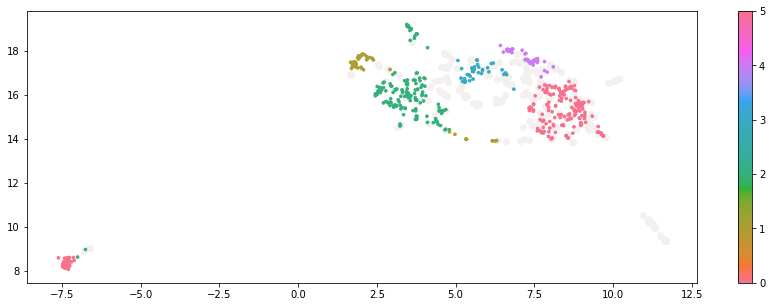

In [35]:
# Visualize clusters
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

fig, ax = plt.subplots(figsize=(15, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#f5f0f0')
plt.scatter(clustered.x, clustered.y, c=clustered.labels,  cmap=cmap, s=7)
plt.colorbar()

In [ ]:
top_n_words

In [37]:
# import pymongo as pm

# myclient = pm.MongoClient(host="localhost",
#                     port=27017,
#                     username="accretioadmin",
#                     password="adminaccretio&2017",
#                    authSource="admin")

# mydb = myclient["topic_detection"]
# mycol = mydb["topic_mamda"]
# mycol.insert_many(top_n_words)

# # for i in top_n_words:
# #     d = i
# #     mycol.update({}, {"$push": {"word-clouds":d }}, True)

In [ ]:
word_cloud = [('client',  0.10164473619525),
 ('achat', 0.0536695191734757),
 ('signature', 0.0446424663176848),
 ('contrat', 0.0438461582647775),
 ('collaborateur', 0.0417429593571477),
 ('deal', 0.0391644732495778),
 ('satisfaction', 0.0391644732495778),
 ('plaisir', 0.0380005840616882),
 ('monde', 0.0373009636334801),
 ('groupe', 0.0371027260902679)]

In [ ]:
word_cloud

In [ ]:
word_cloud2 = [('sport',  0.12164443618528),
 ('vélo', 0.0631695191534727),
 ('bien-être', 0.0446424663176848),
 ('santé', 0.0438461582647775),
 ('cyclisme', 0.0417429593571477),
 ('foot', 0.0391644732495778),
 ('mentale', 0.0391644732495778),
 ('activité', 0.0380005840616882),
 ('terrain', 0.0373009636334801),
 ('force', 0.0371027260902679)]

In [ ]:
outlier = [('lablebi',  0.12164443618528),
 ('sac', 0.0631695191534727),
 ('cloud', 0.0446424663176848),
 ('sa7a', 0.0438461582647775),
 ('azure', 0.0417429593571477),
 ('bug', 0.0391644732495778),
 ('qa', 0.0391644732495778),
 ('easyrun', 0.0380005840616882),
 ('talent', 0.0373009636334801),
 ('git', 0.0371027260902679)]

In [ ]:
word_clouds = dict()
word_clouds[-1] = outlier
word_clouds[0] = word_cloud2

In [41]:
s=0
for i in top_n_words:
    s+= len(i["posts"])

In [42]:
s

495

In [44]:
157*2 +51+46+43+41

495